In [ ]:
import numpy as np
import cv2
from pathlib import Path
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from descriptor_index_pb2 import DescriptorIndex
from utils import plot_imgs
%load_ext autoreload
%autoreload 2

INDEX_ROOT = '../deep-relocalization/data/'
MAP_ROOT = '../deep-relocalization/maps/'

In [45]:
ref_file = 'lindenhof_afternoon_aligned_model-nopca.pb'
query_file = 'lindenhof_wet_aligned_model-nopca.pb'
use_pca = True

In [39]:
def get_index(name):
    index = DescriptorIndex()
    with open(Path(INDEX_ROOT, name).as_posix(), 'rb') as f:
        index.ParseFromString(f.read())
    return index
def get_data_from_index(index):
    positions = np.stack([f.position_vector.data for f in index.frames])
    rotations = np.stack([np.reshape(f.rotation_matrix.data, (3, 3), order='C') for f in index.frames])
    descriptors = np.stack([f.global_descriptor.data for f in index.frames])
    resources = np.stack([f.resource_name for f in index.frames])
    return {'pos': positions, 'rot': rotations, 'descriptors': descriptors, 'res': resources}
def get_image(index, i):
    Path(MAP_ROOT, index.data_name, 'resources/raw_images/')
    return cv2.imread(
        Path(MAP_ROOT, index.data_name, 'resources/raw_images/', '%s.pgm' % index.frames[i].resource_name).as_posix())
def norm(v):
    return np.array(v) / np.linalg.norm(v, axis=-1, keepdims=True)

In [60]:
ref_index = get_index(ref_file)
query_index = get_index(query_file)
ref_data = get_data_from_index(ref_index)
query_data = get_data_from_index(query_index)

In [61]:
proj_dim = 128
if use_pca:
    pca = PCA(n_components=proj_dim)
    ref_data['descriptors'] = norm(pca.fit_transform(norm(ref_data['descriptors'])))
    query_data['descriptors'] = norm(pca.transform(norm(query_data['descriptors'])))

# Ground truth matches

In [43]:
distance_thresh = 3
angle_thresh = 70*np.pi/180.
distances = np.linalg.norm(np.expand_dims(query_data['pos'], axis=1)
                           - np.expand_dims(ref_data['pos'], axis=0), axis=-1)
angle_errors = np.arccos(
    (np.trace(
        np.matmul(np.expand_dims(np.linalg.inv(query_data['rot']), axis=1), np.expand_dims(ref_data['rot'], axis=0)),
        axis1=2, axis2=3) - 1)/2)
gt_matches = np.logical_and(distances < distance_thresh, angle_errors < angle_thresh)
valid = np.any(gt_matches, axis=1)
print(np.mean(valid))

0.5993079584775086


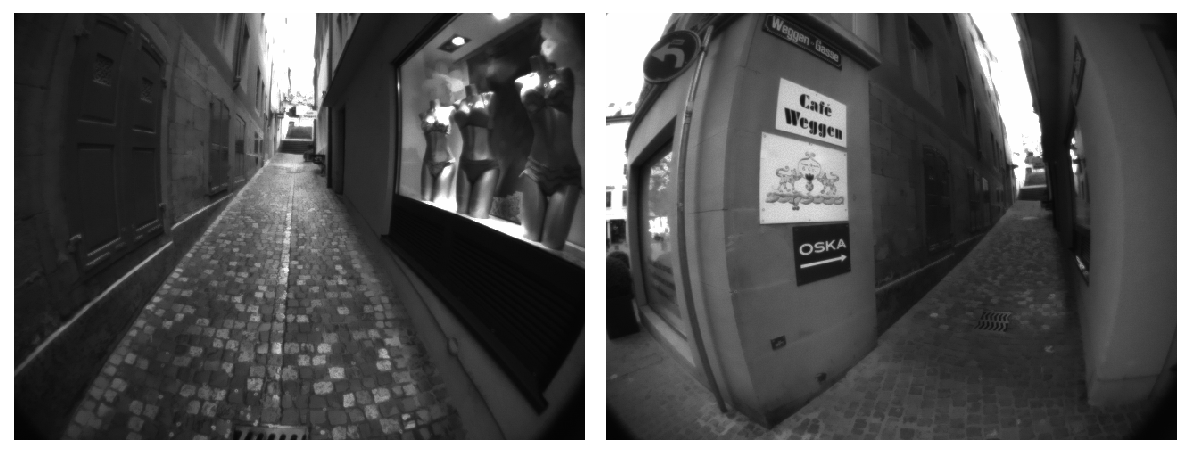

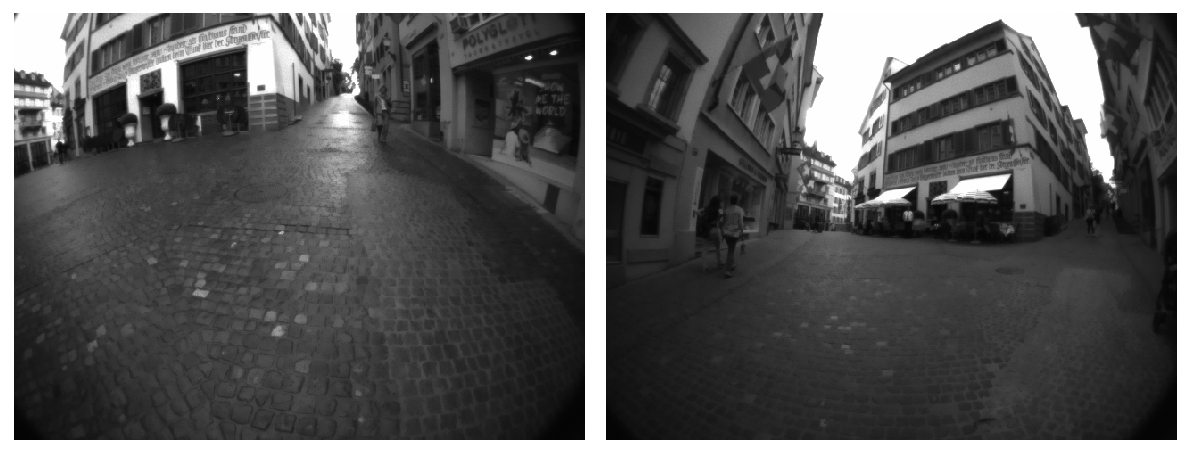

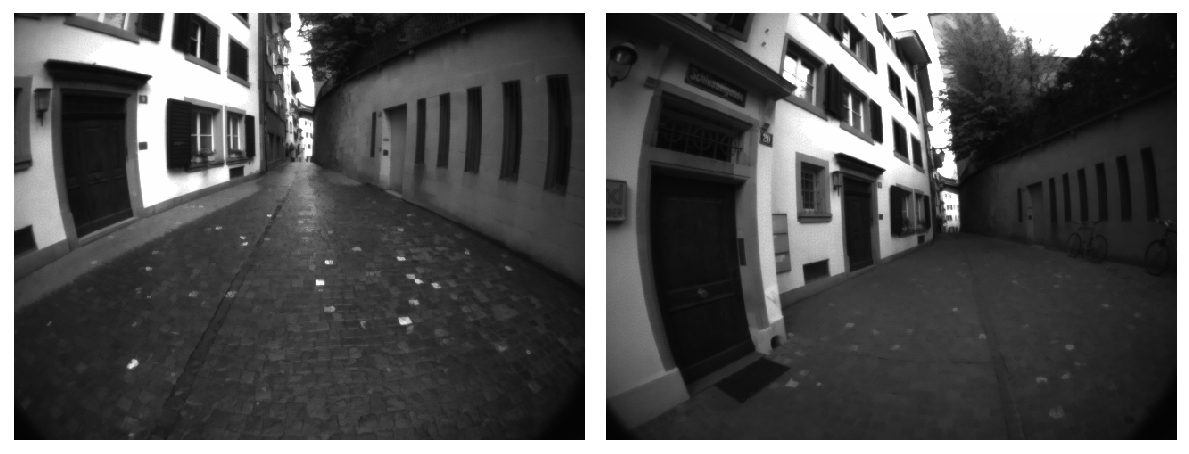

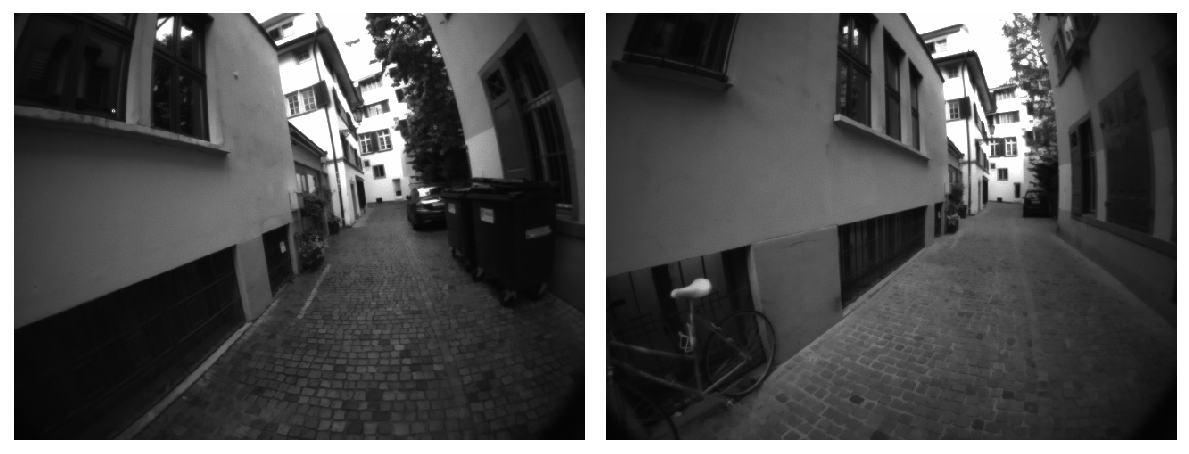

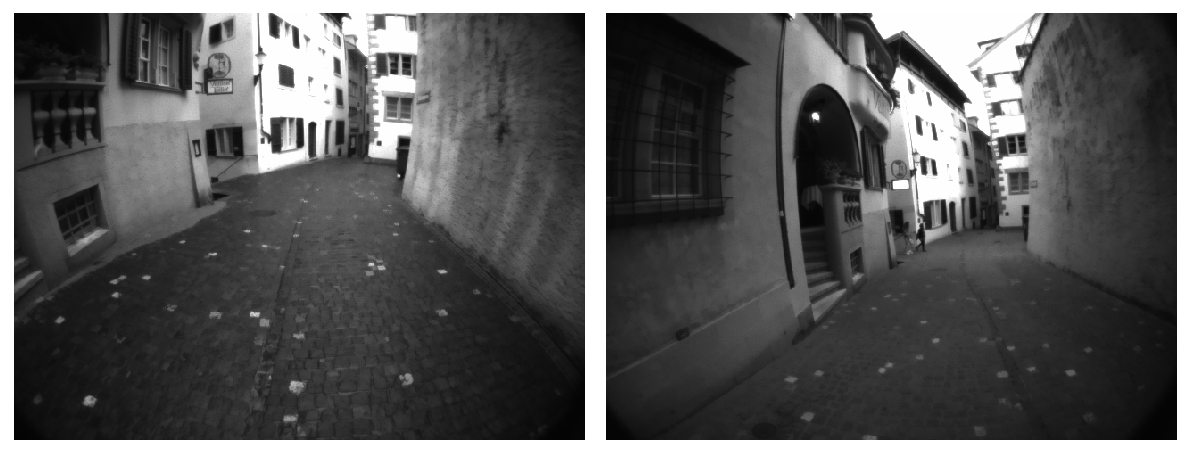

In [6]:
n_test = 5
test_idx = np.random.choice(np.where(valid)[0], size=n_test)
for i in test_idx:
    plot_imgs([get_image(query_index, i), get_image(ref_index, np.where(gt_matches[i])[0][0])])

# Retrieval

In [83]:
max_num_nn = 20
ref_tree = cKDTree(ref_data['descriptors'])
query_distances, idx = ref_tree.query(query_data['descriptors'], k=max_num_nn)
tp = gt_matches[np.expand_dims(np.arange(len(idx)), axis=1), idx]
hit = np.any(tp[valid], axis=1)
miss = np.logical_not(hit)
hit_idx = [idx[valid][i][np.where(tp[valid][i])[0]] for i in range(len(hit))]
miss_idx = [np.where(gt_matches[valid][i])[0] for i in range(len(miss))]
print('Accuracy on valid matches: {}'.format((np.mean(hit), np.sum(hit))))
print('Accuracy on all frames: {}'.format(np.mean(valid)*np.mean(hit)))

Accuracy on valid matches: (0.8071593533487298, 699)
Accuracy on all frames: 0.48373702422145326


On all frames, the current matching-based system achieves a relocalisation rate of 26% with a 3 meters ground-truth distance threshold.

# Hit probability vs number of retrieved NN

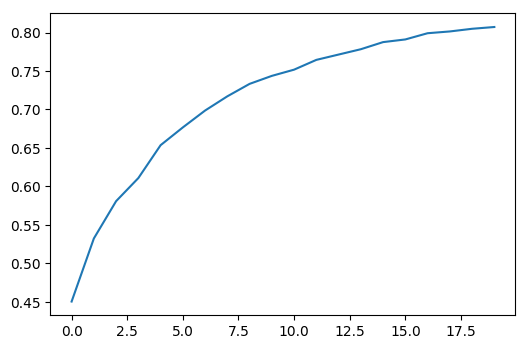

In [63]:
tp_cum = np.cumsum(tp, axis=1)
hit_prob = np.mean(tp_cum[valid] > 0, axis=0)
plt.figure(dpi=100)
plt.plot(hit_prob);

# Distribution of the number of correct counts per request

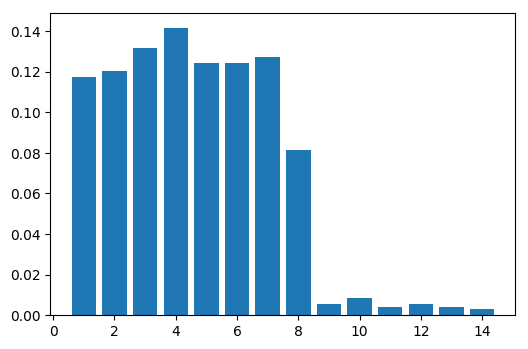

In [64]:
hit_cnt = np.sum(tp[valid][hit], axis=1)
plt.figure(dpi=100)
plt.bar(*(lambda i, c: (i, c/np.sum(c)))(*np.unique(hit_cnt, return_counts=True)));

# Cumulative distribution of the proportion of correct counts per request

Retrieving more than 50.0% of the ground-truth matches in 69% of the queries.
Retrieving more than 100.0% of the ground-truth matches in 21% of the queries.


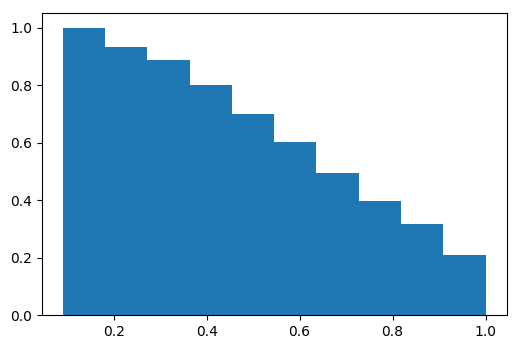

In [91]:
hit_prop = hit_cnt / np.sum(gt_matches[valid][hit], axis=1).astype(np.float)
plt.figure(dpi=100)
plt.hist(hit_prop, bins=10, density=True, cumulative=-1);
f = lambda p: 'Retrieving more than {}% of the ground-truth matches in {:.0f}% of the queries.'.format(
    100*p, 100*np.mean(hit_prop >= p))
print(f(0.5)), print(f(1.));

# Hit

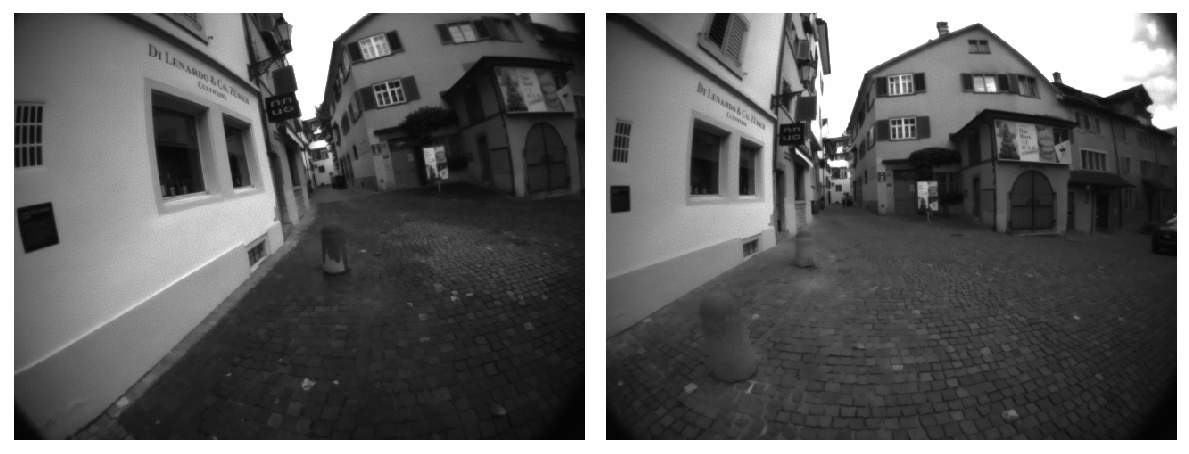

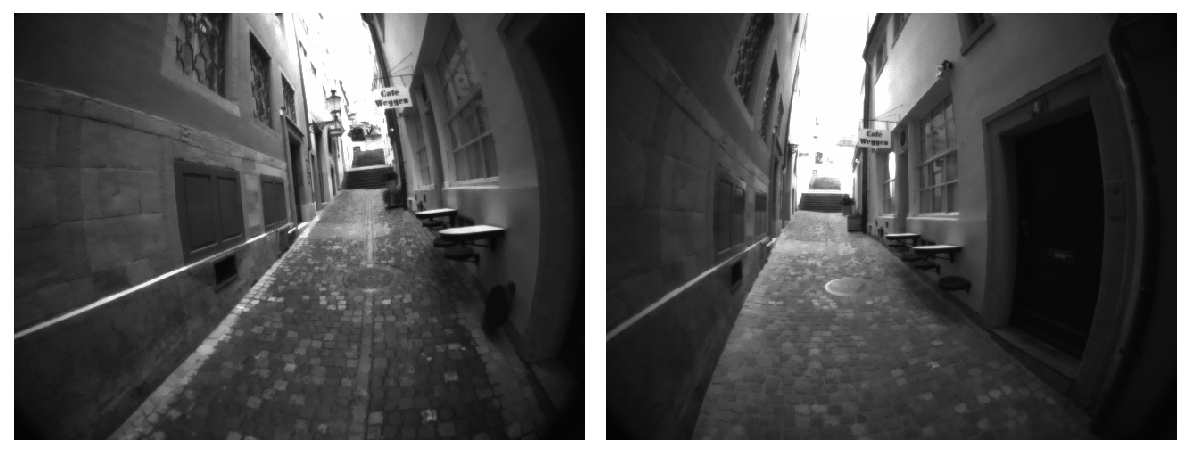

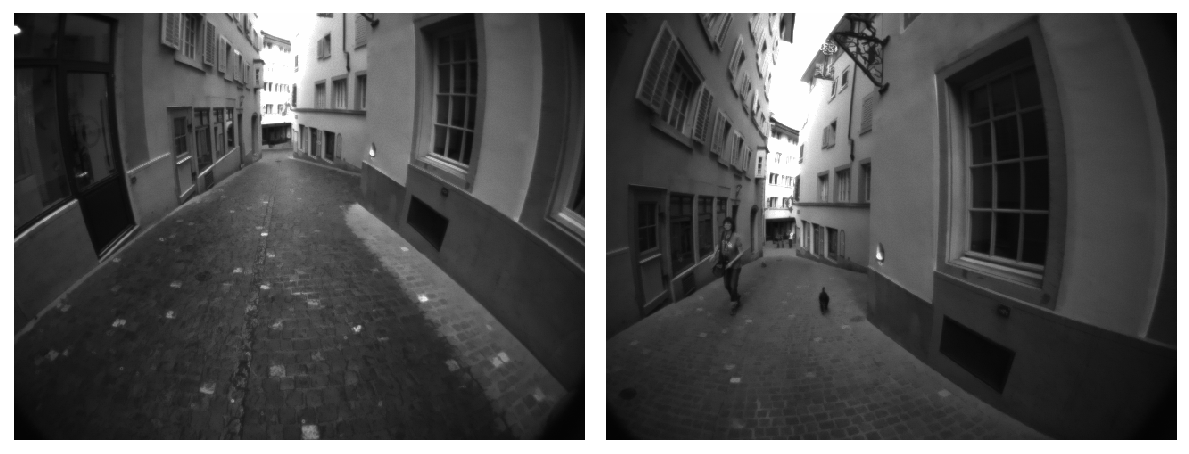

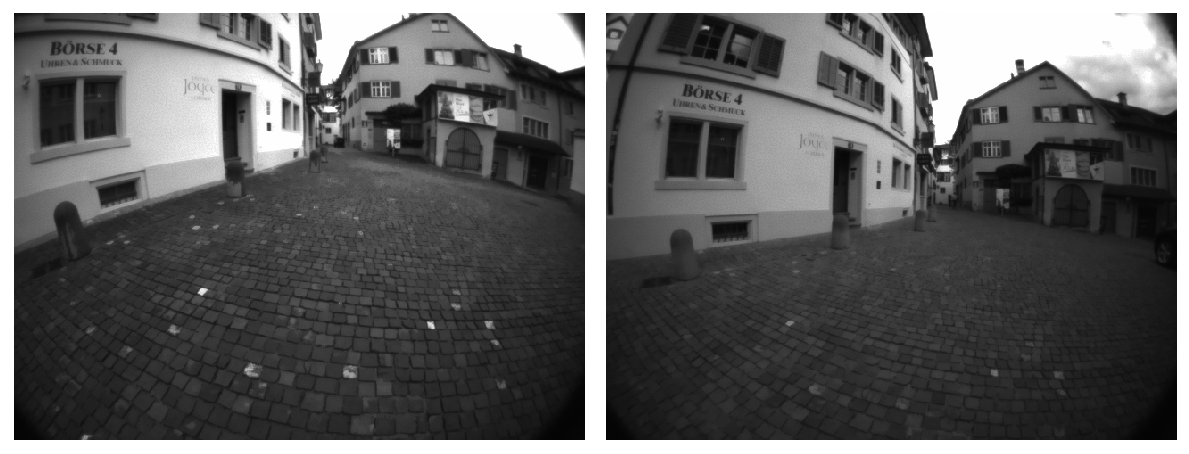

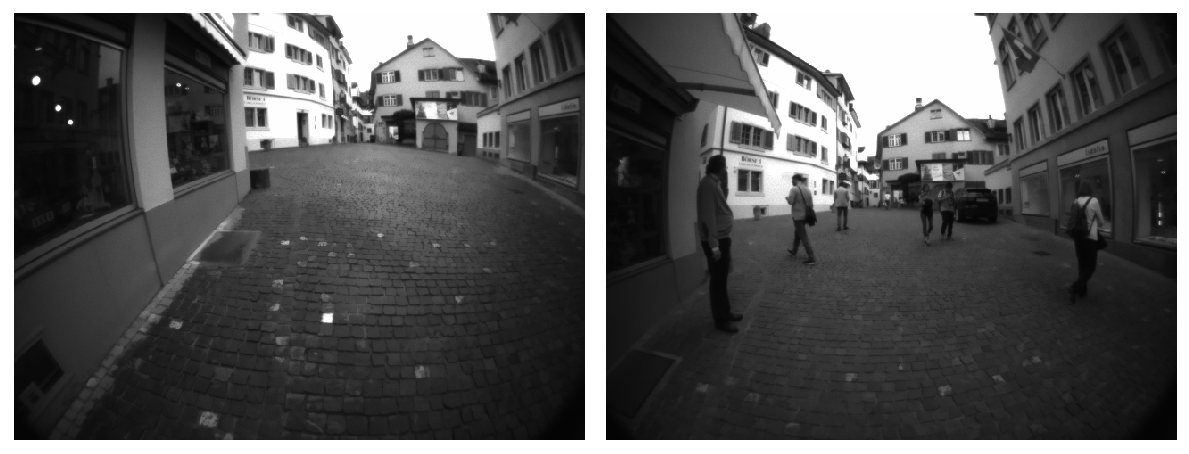

In [85]:
n_test = 5
test_idx = np.random.choice(np.where(hit)[0], size=n_test)
for i in test_idx:
    plot_imgs([get_image(query_index, np.where(valid)[0][i]), get_image(ref_index, hit_idx[i][0])])

# Miss

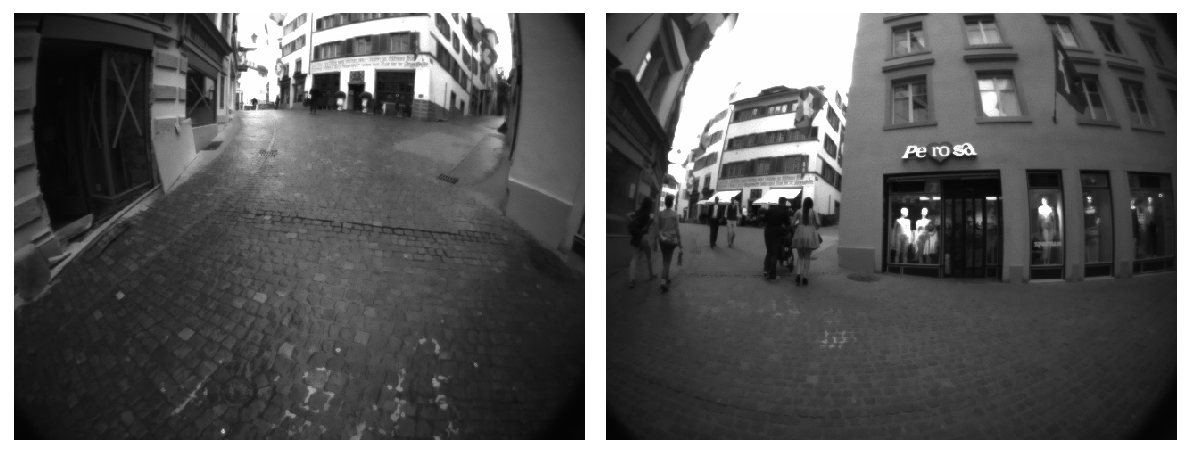

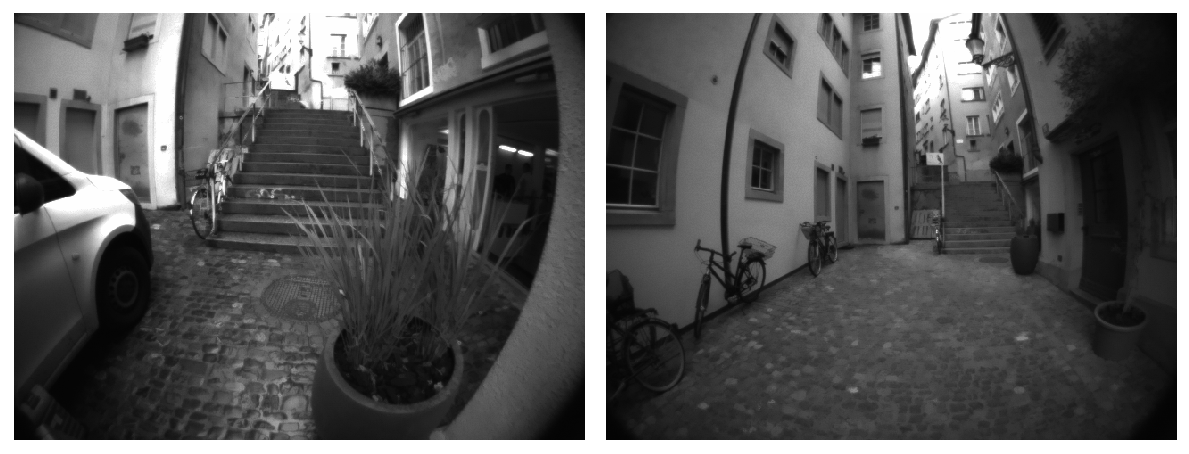

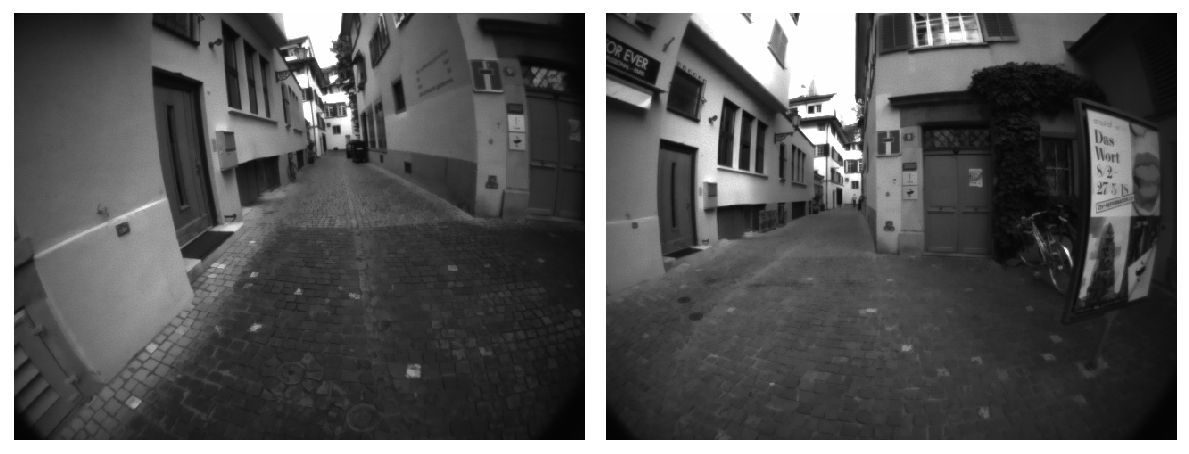

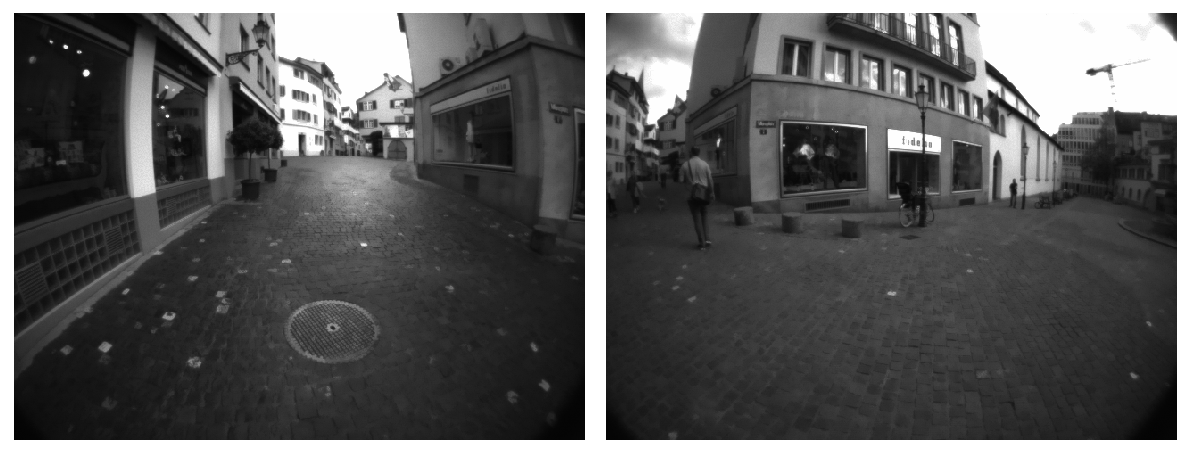

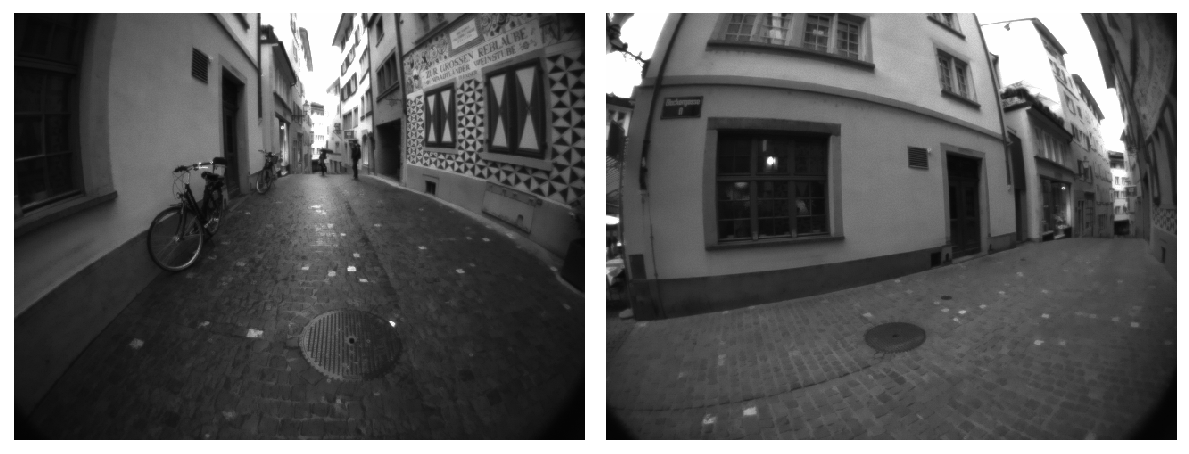

In [75]:
n_test = 5
test_idx = np.random.choice(np.where(miss)[0], size=n_test)
for i in test_idx:
    plot_imgs([get_image(query_index, np.where(valid)[0][i]), get_image(ref_index, miss_idx[i][0])])

# Distances

In [76]:
hit_dist = distances[np.expand_dims(np.arange(len(idx)), axis=1), idx][valid][hit]
miss_dist = distances[np.expand_dims(np.arange(len(idx)), axis=1), idx][valid][miss]

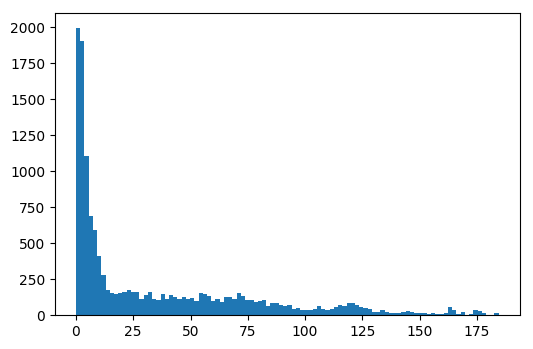

In [77]:
plt.figure(dpi=100)
plt.hist(hit_dist.reshape(-1), bins=100);

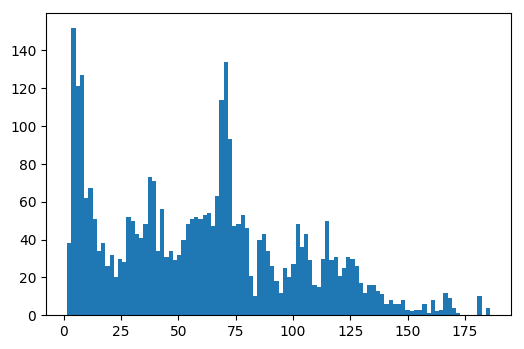

In [78]:
plt.figure(dpi=100)
plt.hist(miss_dist.reshape(-1), bins=100);

In [79]:
np.mean(hit_dist)

35.6693385108113

In [80]:
np.mean(miss_dist)

61.01678837448755